In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV


In [2]:
#df_master = pd.read_pickle('../master/master.pkl')
df_master = pd.read_parquet('../master/master.parquet')

In [3]:
df_master.columns

Index(['user_id', 'dateString', 'userDate', 'isEmployed', 'isInsider',
       'hasLogin', 'firstActivity', 'hasConnect', 'role', 'minHour',
       'probMinLogonRole', 'maxHour', 'probMaxLogoutRole', 'webCount',
       'webQuestionableUsage', 'countPC', 'employee_name', 'psyc_O', 'psyc_C',
       'psyc_E', 'psyc_A', 'psyc_N', 'numMonthsEmployed', 'sumExtEmailSize',
       'sumExtEmailAttachments', 'numExtEmails', 'probLogonUser',
       'probLogoffUser', 'changeNumRole'],
      dtype='object')

In [4]:
X = df_master.drop(['user_id', 'dateString', 'userDate','minHour','maxHour','isInsider','employee_name'], axis=1)

In [5]:
X = pd.get_dummies(X, columns=['role'])

In [6]:
X = X.fillna(-999)

In [ ]:
X

In [7]:
y = df_master['isInsider']

In [ ]:
y

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# calculate the scale_pos_weight parameter
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

10319.0


In [10]:
dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999)
dtest = xgb.DMatrix(X_test, label=y_test, missing=-999)

In [ ]:
params = {
    'max_depth': 10, 
    'eta': 0.1, 
    'objective': 'binary:logistic',
    'scale_pos_weight': scale_pos_weight
    }

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=10)

In [ ]:
predictions = model.predict(dtest)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions.round()))

In [ ]:
df_test = pd.concat([X_test,y_test], axis=1)
df_test['predictions'] = predictions
df_test[(df_test['predictions'] >= .5) & (df_test['isInsider'] != 1)]

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

fig, ax = plt.subplots(figsize=(20, 8))
xgb.plot_tree(model, ax=ax, num_trees=99)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax)
plt.show()

In [ ]:
sample = pd.DataFrame({'isEmployed':[1], 
                       'hasLogin':[4], 
                       'firstActivity':[1], 
                       'hasConnect':[2],
                       'probLogonRole':[.1], 
                       'webCount':[0], 
                       'countPC':[0], 
                       'psyc_O':[10], 
                       'psyc_C':[20], 
                       'psyc_E':[30],
                       'psyc_A':[99], 
                       'psyc_N':[10], 
                       'numMonthsEmployed':[1], 
                       'sumExtEmailSize':[40000],
                       'sumExtEmailAttachments':[0], 
                       'numExtEmails':[0], 
                       'probLogonUser':[0],
                       'webQuestionableUsage':[200], 
                       'role_Accountant':[0],
                       'role_AdministrativeAssistant':[0], 
                       'role_AdministrativeStaff':[0],
                       'role_AssemblySupervisor':[0], 
                       'role_Attorney':[0], 
                       'role_ChiefEngineer':[0],
                       'role_ComputerProgrammer':[0], 
                       'role_ComputerScientist':[0],
                       'role_ComputerTrainer':[0], 
                       'role_Director':[0], 
                       'role_ElectricalEngineer':[0],
                       'role_Engineer':[0],
                       'role_FieldServiceEngineer':[0], 
                       'role_FinancialAnalyst':[0],
                       'role_HardwareEngineer':[0], 
                       'role_HealthSafetyEngineer':[0],
                       'role_HumanResourceSpecialist':[0], 
                       'role_ITAdmin':[0],
                       'role_IndustrialEngineer':[1], 
                       'role_LabManager':[0], 
                       'role_ManagementTrainer':[0],
                       'role_Manager':[0], 
                       'role_MaterialsEngineer':[0], 
                       'role_Mathematician':[0],
                       'role_MechanicalEngineer':[0], 
                       'role_Nurse':[0], 
                       'role_NursePractitioner':[0],
                       'role_Physicist':[0], 
                       'role_President':[0], 
                       'role_ProductionLineWorker':[0],
                       'role_PurchasingClerk':[0], 
                       'role_Salesman':[0], 
                       'role_Scientist':[0],
                       'role_SecurityGuard':[0],
                       'role_SoftwareEngineer':[0], 
                       'role_Statistician':[0],
                       'role_SystemsEngineer':[0], 
                       'role_TechnicalTrainer':[0], 
                       'role_Technician':[0],
                       'role_TestEngineer':[0], 
                       'role_VicePresident':[0]})

In [ ]:
model.predict(xgb.DMatrix(sample))

In [ ]:
X.columns

In [ ]:
scores = model.get_score(importance_type='weight')

# Display feature importance scores
for feature, score in scores.items():
    print('{}: {}'.format(feature, score))

In [ ]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, 'objective': 'binary:logistic')

In [ ]:
scores_KFold = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
np.mean(scores_KFold)

In [112]:
cv = RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42)


In [113]:
hyperparameter_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='auc', random_state=42)
# scoring='f1_micro' cant be used with objective

params_grid = {
    'max_depth': [10, 13, 15],
    'learning_rate': [0.3, 0.2, 0.1],
    'n_estimators': [100, 500, 1000],
#    'gamma': [0, 0.1, 0.5],
    'subsample': [0.8, 0.9, 1.0],
#    'colsample_bytree': [0.8, 0.9, 1.0],
     }

In [114]:
xgb_grid = GridSearchCV(hyperparameter_model, param_grid=params_grid, cv=cv, n_jobs=-1, verbose=2)

In [115]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.8; total time= 2.7min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time= 2.8min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time= 2.8min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.8; total time= 2.9min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time= 2.9min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time= 2.9min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time= 2.9min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time= 3.0min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.8; total time= 3.0min
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.8; total time= 3.0mi

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     import...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                

In [116]:
best_model = xgb_grid.best_estimator_

In [117]:
best_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 10319.0,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [118]:
y_predictions = best_model.predict(X_test)

In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103190
           1       0.57      0.80      0.67        10

    accuracy                           1.00    103200
   macro avg       0.79      0.90      0.83    103200
weighted avg       1.00      1.00      1.00    103200



In [231]:
contamination = .00009
contamination_range = np.linspace(contamination, .1, 10)
contamination_range

array([9.00000000e-05, 1.11911111e-02, 2.22922222e-02, 3.33933333e-02,
       4.44944444e-02, 5.55955556e-02, 6.66966667e-02, 7.77977778e-02,
       8.88988889e-02, 1.00000000e-01])

In [224]:
df_preds = pd.concat([X_test, y_test], axis=1)
df_preds['predictions'] = y_predictions
df_preds[df_preds['isInsider'] == 1].index

Int64Index([434187, 434169, 434212, 434211, 44557, 434221, 44572, 434207,
            434177, 434219],
           dtype='int64')

In [134]:
pd.options.display.max_columns = None
df_master[df_master.index.isin((df_preds[df_preds['isInsider'] == 1].index))]

,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,role,minHour,probMinLogonRole,maxHour,probMaxLogoutRole,webCount,webQuestionableUsage,countPC,employee_name,psyc_O,psyc_C,psyc_E,psyc_A,psyc_N,numMonthsEmployed,sumExtEmailSize,sumExtEmailAttachments,numExtEmails,probLogonUser,probLogoffUser,changeNumRole
44557,CSF0929,20100701,CSF0929_20100701,1,1,2.0,1.0,2.0,ProductionLineWorker,1.0,0.000686,17.0,0.208692,58.0,7.0,1.0,Chaney Sean Fuentes,38,35,39,47,28,7,NaN,NaN,NaN,0.007492,0.389821,8
44572,CSF0929,20100716,CSF0929_20100716,1,1,2.0,NaN,2.0,ProductionLineWorker,3.0,0.000765,17.0,0.208692,61.0,5.0,1.0,Chaney Sean Fuentes,38,35,39,47,28,7,NaN,NaN,NaN,0.003534,0.389821,8
434169,CCH0959,20100802,CCH0959_20100802,1,1,1.0,NaN,2.0,IndustrialEngineer,7.0,0.244441,16.0,0.331523,158.0,16.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,20118.0,0.0,1.0,0.306412,0.331197,0
434177,CCH0959,20100810,CCH0959_20100810,1,1,1.0,NaN,1.0,IndustrialEngineer,7.0,0.244441,16.0,0.331523,158.0,19.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,44966.0,0.0,1.0,0.306412,0.331197,0
434187,CCH0959,20100820,CCH0959_20100820,1,1,1.0,NaN,3.0,IndustrialEngineer,8.0,0.255899,15.0,0.285965,224.0,31.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,28163.0,0.0,1.0,0.334501,0.309716,0
434207,CCH0959,20100909,CCH0959_20100909,1,1,1.0,NaN,7.0,IndustrialEngineer,8.0,0.255899,16.0,0.331523,164.0,17.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,22497.0,0.0,1.0,0.334501,0.331197,1
434211,CCH0959,20100913,CCH0959_20100913,1,1,1.0,NaN,3.0,IndustrialEngineer,8.0,0.255899,15.0,0.285965,166.0,12.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,101630.0,0.0,4.0,0.334501,0.309716,1
434212,CCH0959,20100914,CCH0959_20100914,1,1,1.0,NaN,7.0,IndustrialEngineer,8.0,0.255899,15.0,0.285965,157.0,17.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,NaN,NaN,NaN,0.334501,0.309716,1
434219,CCH0959,20100921,CCH0959_20100921,1,1,1.0,NaN,2.0,IndustrialEngineer,8.0,0.255899,16.0,0.331523,202.0,22.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,NaN,NaN,NaN,0.334501,0.331197,1
434221,CCH0959,20100923,CCH0959_20100923,1,1,1.0,NaN,6.0,IndustrialEngineer,7.0,0.244441,16.0,0.331523,328.0,26.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,19999.0,0.0,1.0,0.306412,0.331197,1


In [122]:
y_train.value_counts()

0    412760
1        40
Name: isInsider, dtype: int64

In [123]:
df_master[df_master.index.isin((df_preds[(df_preds['isInsider'] == 0) & (df_preds['predictions'] == 1)].index))]


,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,role,minHour,...,psyc_E,psyc_A,psyc_N,numMonthsEmployed,sumExtEmailSize,sumExtEmailAttachments,numExtEmails,probLogonUser,probLogoffUser,changeNumRole
44579,CSF0929,20100723,CSF0929_20100723,1,0,1.0,NaN,NaN,ProductionLineWorker,8.0,...,39,47,28,7,NaN,NaN,NaN,0.385650,0.389821,8
433987,CCH0959,20100201,CCH0959_20100201,1,0,1.0,NaN,1.0,IndustrialEngineer,8.0,...,23,40,21,9,26884.0,0.0,1.0,0.334501,0.331197,0
434008,CCH0959,20100222,CCH0959_20100222,1,0,1.0,NaN,2.0,IndustrialEngineer,7.0,...,23,40,21,9,NaN,NaN,NaN,0.306412,0.331197,0
434043,CCH0959,20100329,CCH0959_20100329,1,0,1.0,NaN,2.0,IndustrialEngineer,8.0,...,23,40,21,9,85951.0,0.0,3.0,0.334501,0.309716,0
434080,CCH0959,20100505,CCH0959_20100505,1,0,1.0,NaN,2.0,IndustrialEngineer,7.0,...,23,40,21,9,50767.0,1.0,2.0,0.306412,0.331197,0
434150,CCH0959,20100714,CCH0959_20100714,1,0,1.0,NaN,2.0,IndustrialEngineer,8.0,...,23,40,21,9,NaN,NaN,NaN,0.334501,0.331197,0


In [240]:
df_master[df_master.index.isin((df_preds[(df_preds['isInsider'] == 1) & (df_preds['predictions'] == 0)].index))]


,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,role,minHour,probMinLogonRole,maxHour,probMaxLogoutRole,webCount,webQuestionableUsage,countPC,employee_name,psyc_O,psyc_C,psyc_E,psyc_A,psyc_N,numMonthsEmployed,sumExtEmailSize,sumExtEmailAttachments,numExtEmails,probLogonUser,probLogoffUser,changeNumRole
434169,CCH0959,20100802,CCH0959_20100802,1,1,1.0,NaN,2.0,IndustrialEngineer,7.0,0.244441,16.0,0.331523,158.0,16.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,20118.0,0.0,1.0,0.306412,0.331197,0
434177,CCH0959,20100810,CCH0959_20100810,1,1,1.0,NaN,1.0,IndustrialEngineer,7.0,0.244441,16.0,0.331523,158.0,19.0,1.0,Cedric Cyrus Harrison,23,37,23,40,21,9,44966.0,0.0,1.0,0.306412,0.331197,0


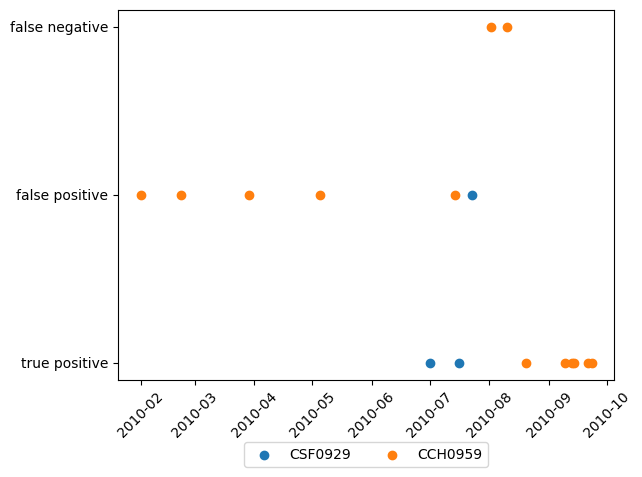

In [196]:
df_events = df_master[df_master.index.isin(df_preds[((df_preds['isInsider'] == 0) & (df_preds['predictions'] == 1)) | ((df_preds['isInsider'] == 1))].index)][['user_id','dateString','isInsider']].join(df_preds['predictions'])
df_events['date'] = pd.to_datetime(df_events['dateString'])

def predtype(row):
    if row['isInsider'] == 1 & row['predictions'] == 1:
        return 'true positive'
    elif (row['isInsider'] == 1) & (row['predictions'] == 0):
        return 'false negative'
    elif (row['isInsider'] == 0) & (row['predictions'] == 1):
        return 'false positive'



df_events['predtype'] = df_events.apply(predtype, axis=1)

df_events[['date','predtype', 'user_id']]
labels = df_events['user_id'].unique()
color_dict = {'CSF0929': 'green', 'CCH0959': 'blue'}
df_events['color'] = df_events['user_id'].map(color_dict)

fig, ax = plt.subplots()
for label in labels:
    group = df_events[df_events['user_id'] == label]
    ax.scatter(group['date'], group['predtype'],  label=label)





#plt.scatter(df_events['date'], df_events['predtype'], c=df_events['color'], labels=df_events['user_id'])

plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()


<Axes: >

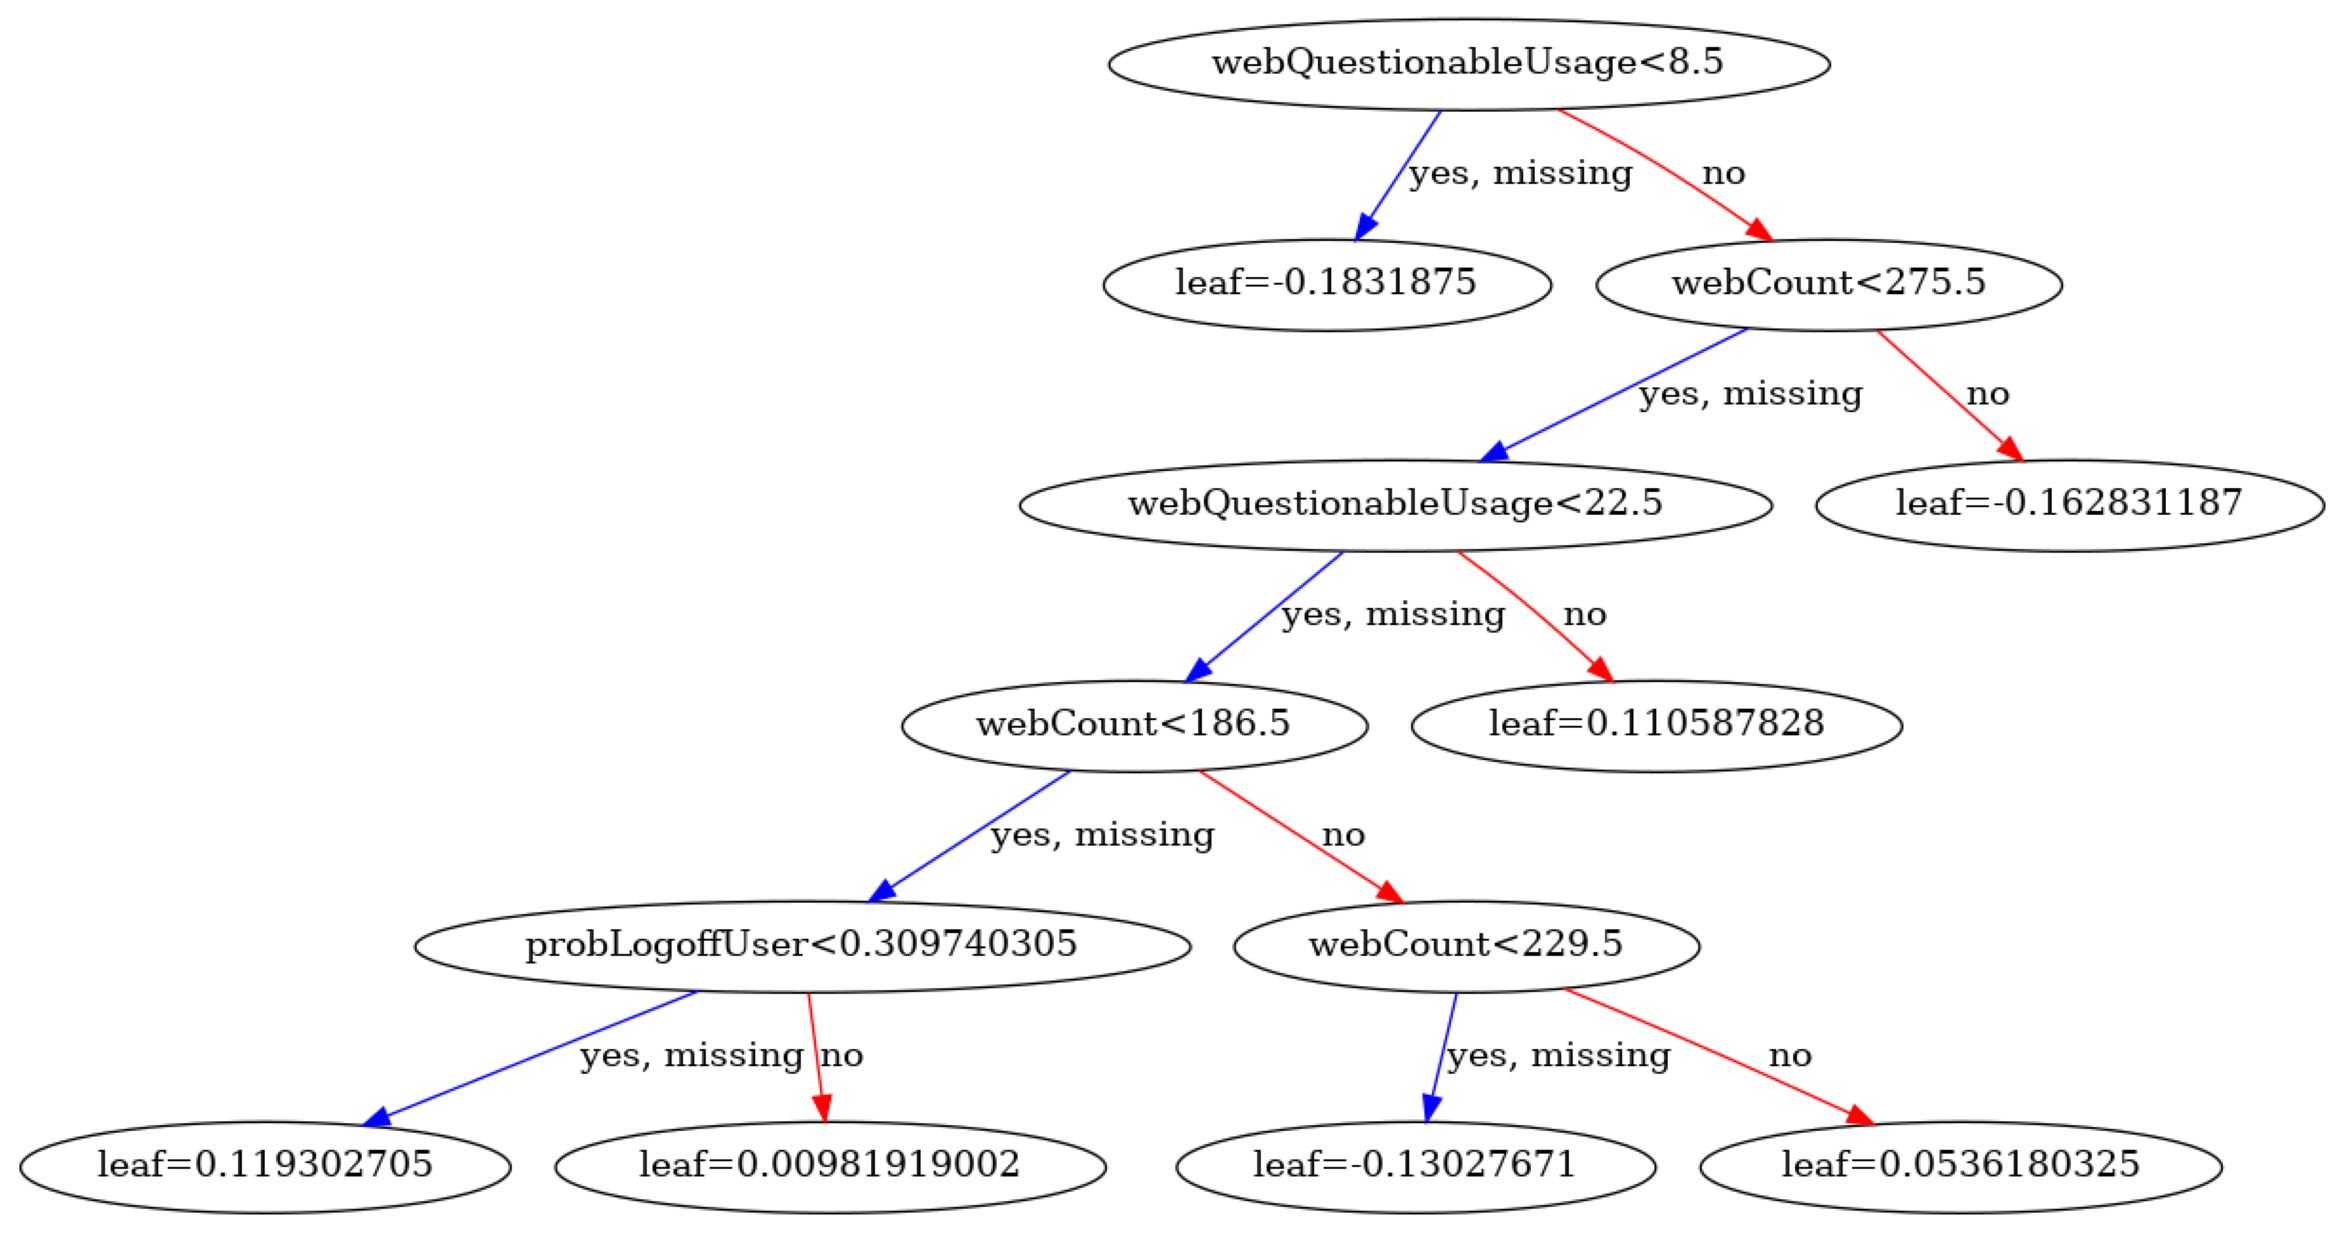

In [243]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(best_model, num_trees=100, ax=ax)


In [126]:
len(df_master[df_master['isInsider'] == 1]['user_id'])

50

In [127]:
len(df_preds[df_preds['isInsider'] == 1])

10

In [128]:
y_train.value_counts()

0    412760
1        40
Name: isInsider, dtype: int64

In [129]:

df_master[df_master.index.isin(df_preds[(df_preds['isInsider'] == 1) & (df_preds['predictions'] == 0)].index)]

,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,role,minHour,...,psyc_E,psyc_A,psyc_N,numMonthsEmployed,sumExtEmailSize,sumExtEmailAttachments,numExtEmails,probLogonUser,probLogoffUser,changeNumRole
434169,CCH0959,20100802,CCH0959_20100802,1,1,1.0,NaN,2.0,IndustrialEngineer,7.0,...,23,40,21,9,20118.0,0.0,1.0,0.306412,0.331197,0
434177,CCH0959,20100810,CCH0959_20100810,1,1,1.0,NaN,1.0,IndustrialEngineer,7.0,...,23,40,21,9,44966.0,0.0,1.0,0.306412,0.331197,0


In [130]:
features = []

for feat, importance in zip(X_train.columns, best_model.feature_importances_):
    if importance != 0:
        features.append(feat)

features

['hasLogin',
 'hasConnect',
 'probMinLogonRole',
 'probMaxLogoutRole',
 'webCount',
 'webQuestionableUsage',
 'psyc_C',
 'psyc_E',
 'psyc_A',
 'psyc_N',
 'numMonthsEmployed',
 'sumExtEmailSize',
 'sumExtEmailAttachments',
 'numExtEmails',
 'probLogonUser',
 'probLogoffUser',
 'changeNumRole',
 'role_IndustrialEngineer',
 'role_ProductionLineWorker']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

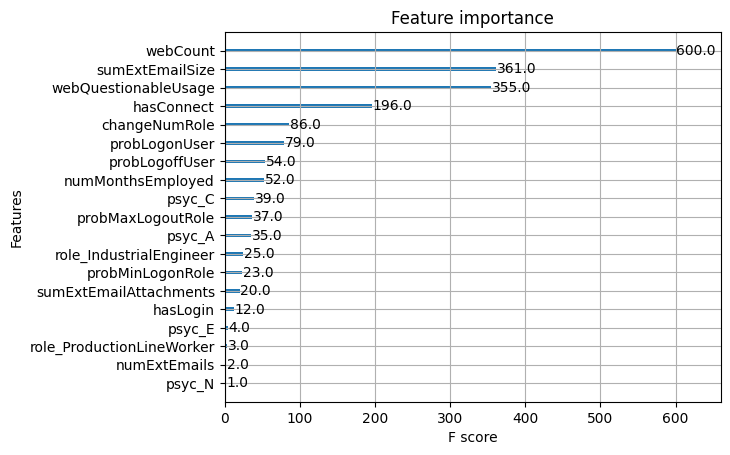

In [131]:
xgb.plot_importance(best_model)

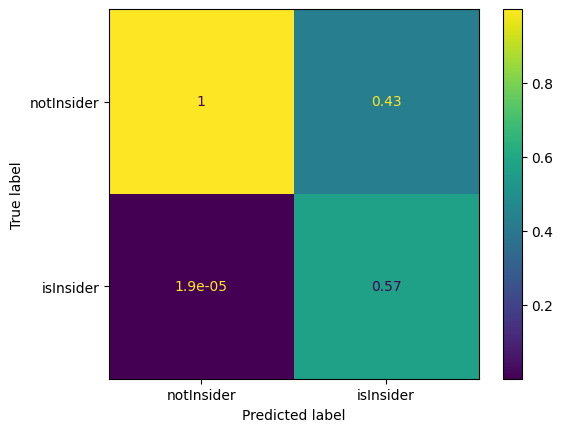

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predictions, normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=['notInsider','isInsider'])
cmd.plot()

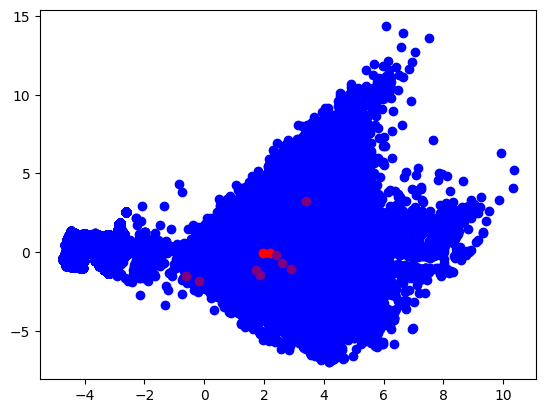

In [227]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_master2 = pd.read_parquet('../master/master.parquet')
XforPCA = df_master2.drop(['user_id', 'dateString', 'userDate','minHour','maxHour','isInsider','employee_name'], axis=1)
XforPCA = pd.get_dummies(XforPCA, columns=['role'])


scaler = StandardScaler()
XforPCA.fillna(0, inplace=True)
df_masterstd = scaler.fit_transform(XforPCA)

pca = PCA(n_components=2)

df_pca = pca.fit_transform(df_masterstd)

color_map = np.array(['blue'] * len(indexForX))
color_map[434169] = 'red'
color_map[434177] = 'red'

plt.scatter(df_pca[:, 0], df_pca[:, 1], c='blue', zorder=1)
plt.scatter(df_pca[434169, 0], df_pca[434169, 1], c='red', zorder=10)
plt.scatter(df_pca[434177, 0], df_pca[434169, 1], c='red', zorder=10)
for num in [434187, 434212, 434211, 44557, 434221, 44572, 434207, 434219]:
    plt.scatter(df_pca[num, 0], df_pca[num, 1], c='purple', zorder=10)


plt.show()